<h1>Title</h1>

**Can we predict whether a person has a heart disease based on their age, cholesterol, and resting blood pressure?**

<h1>Introduction</h1>

Heart disease, also known as cardiovascular disease, refers to a range of conditions that affect the heart and blood vessels. Among these conditions is Coronary Artery Disease (CAD), which is characterized by the narrowing of blood vessels leading to the heart. According to the World Health Organization (WHO), cardiovascular disease is the leading cause of death worldwide, with CAD accounting for the majority of these deaths. This research project looks into data provided by the Hungarian institute of Cardiology (processed.hungarian.data) to answer the question, "Can we use age, cholesterol and resting blood pressure measurements that are available to us to predict the likelihood of an individual having heart disease?" The original database contains 76 attributes, but we will be working with 14 important comma-separated attributes including age, cholesterol levels, and resting blood pressure.

<h1>Preliminary Exploratory Data Analysis</h1>

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

Reading from web:

In [2]:
data <- read_delim("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data", delim=",", col_names = FALSE)
colnames(data) <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")
head(data)

Rows: 294 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): X4, X5, X6, X7, X8, X9, X11, X12, X13
dbl (5): X1, X2, X3, X10, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>
28,1,2,130,132,0,2,185,0,0,?,?,?,0
29,1,2,120,243,0,0,160,0,0,?,?,?,0
29,1,2,140,?,0,0,170,0,0,?,?,?,0
30,0,1,170,237,0,1,170,0,0,?,?,6,0
31,0,2,100,219,0,1,150,0,0,?,?,?,0
32,0,2,105,198,0,0,165,0,0,?,?,?,0


Cleaning, wrangling, and tidying:

In [3]:
tidy_data <- data |>
    select(age, trestbps, chol, num)

head(tidy_data)

age,trestbps,chol,num
<dbl>,<chr>,<chr>,<dbl>
28,130,132,0
29,120,243,0
29,140,?,0
30,170,237,0
31,100,219,0
32,105,198,0


Splitting into training and testing data:

In [4]:
set.seed(3456)
data_split <- initial_split(tidy_data, prop = 3/4, strata = num)
data_train <- training(data_split)
data_test <- testing(data_split)

# data_train
# data_test

Summarization of the training data:

In [5]:
missing_rows <- data_train |>
    filter(trestbps == '?' | chol == '?') |>
    count()

avg_age <- data_train |>
    select(age) |>
    colMeans()

avg_chol <- data_train |>
    select(chol) |>
    filter(chol != '?') |>
    mutate(chol = as.numeric(chol)) |>
    colMeans()

avg_trestbps <- data_train |>
    select(trestbps) |>
    filter(trestbps != '?') |>
    mutate(trestbps = as.numeric(trestbps)) |>
    colMeans()

summary_table <- data.frame(n = missing_rows, observations_used = 3, mean_age = avg_age, mean_chol = avg_chol, mean_trestbps = avg_trestbps) |>
    as_tibble() |>
    mutate(incomplete_rows = n) |>
    select(!n)

summary_table

observations_used,mean_age,mean_chol,mean_trestbps,incomplete_rows
<dbl>,<dbl>,<dbl>,<dbl>,<int>
3,48.37273,254.4902,132.589,17


`summarise()` has grouped output by 'age'. You can override using the `.groups`
argument.
`summarise()` has grouped output by 'chol'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'trestbps'. You can override using the
`.groups` argument.
Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”
Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”
Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”


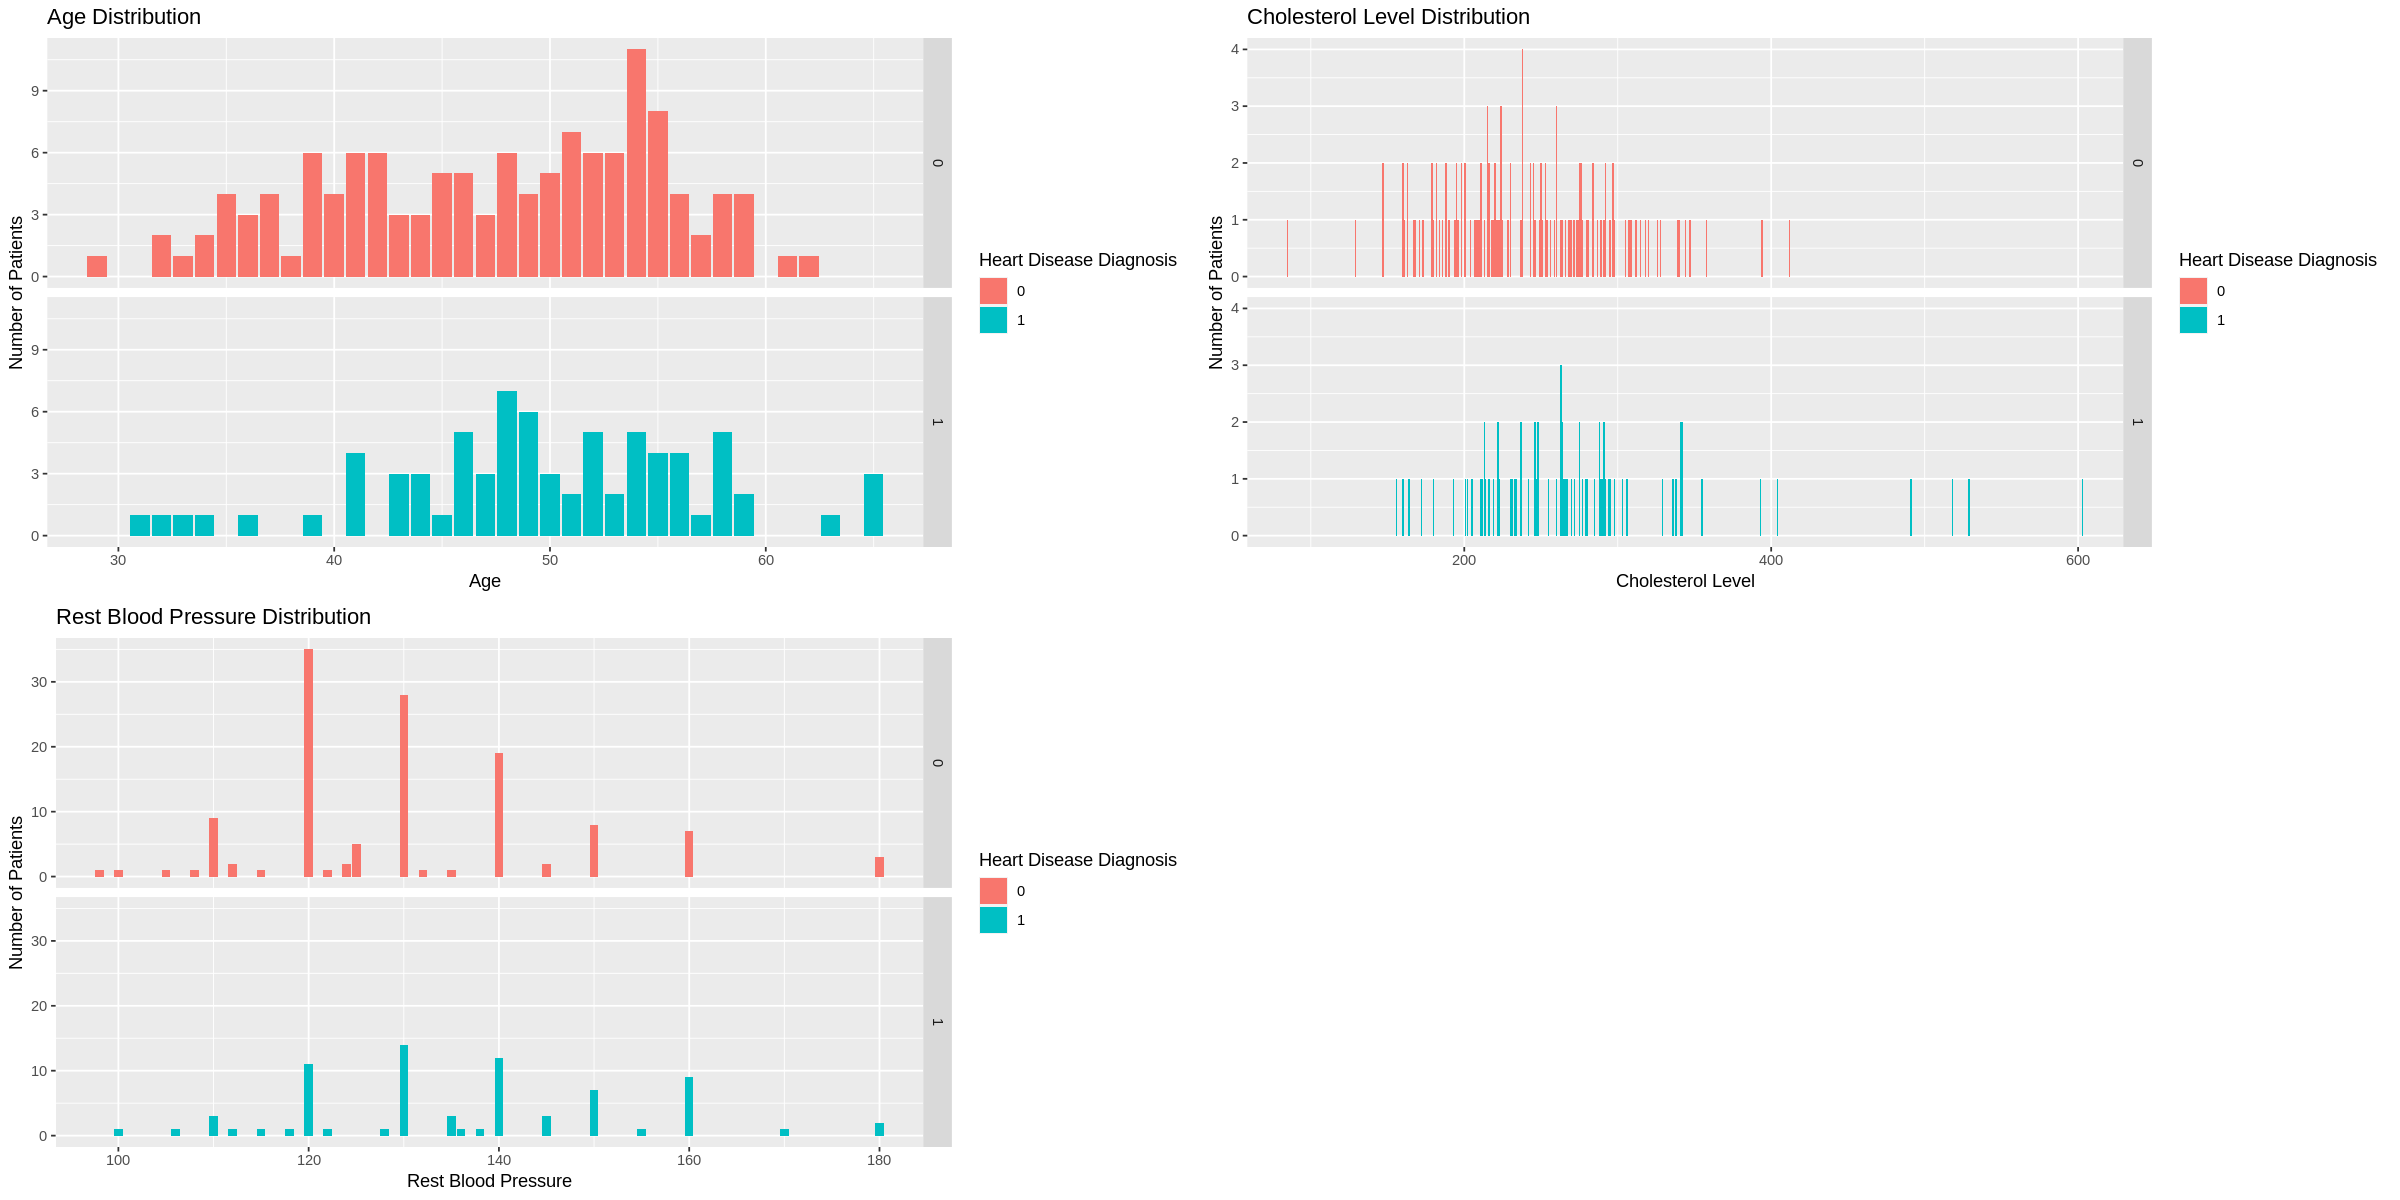

In [6]:
plottable_train_data <- data_train |>
    filter(chol != '?' & trestbps != '?') |>
    mutate(chol = as.numeric(chol), trestbps = as.numeric(trestbps), num = as.factor(num))

age_vs_count_data <- plottable_train_data |>
    group_by(age, num) |>
    summarize(count = n()) |>
    ungroup()

chol_vs_count_data <- plottable_train_data |>
    group_by(chol, num) |>
    summarize(count = n()) |>
    ungroup()

trestbps_vs_count_data <- plottable_train_data |>
    group_by(trestbps, num) |>
    summarize(count = n()) |>
    ungroup()

options(repr.plot.width = 10, repr.plot.height = 5)

age_vs_count_plot <- age_vs_count_data |>
    ggplot(aes(x = age, y = count, fill = num)) +
    geom_histogram(stat = "identity") +
    facet_grid(vars(num)) +
    labs(x = "Age", y = "Number of Patients", fill = "Heart Disease Diagnosis") +
    ggtitle("Age Distribution")
# age_vs_count_plot

chol_vs_count_plot <- chol_vs_count_data |>
    ggplot(aes(x = chol, y = count, fill = num)) +
    geom_histogram(stat = "identity") +
    facet_grid(vars(num)) +
    labs(x = "Cholesterol Level", y = "Number of Patients", fill = "Heart Disease Diagnosis") +
    ggtitle("Cholesterol Level Distribution")
# chol_vs_count_plot

trestbps_vs_count_plot <- trestbps_vs_count_data |>
    ggplot(aes(x = trestbps, y = count, fill = num)) +
    geom_histogram(stat = "identity") +
    facet_grid(vars(num)) +
    labs(x = "Rest Blood Pressure", y = "Number of Patients", fill = "Heart Disease Diagnosis") +
    ggtitle("Rest Blood Pressure Distribution")
# trestbps_vs_count_plot

options(repr.plot.width = 20, repr.plot.height = 10)
total_grid <- plot_grid(age_vs_count_plot, chol_vs_count_plot, trestbps_vs_count_plot)

total_grid

<h1>Methods</h1>


We are analyzing the Heart Disease dataset with specific focus on the processed Hungarian data. The aim is to develop a classification model that will predict the risk of an individual having CAD based on their age, cholesterol level, and resting blood pressure. Since CAD is caused by the narrowing of blood vessels as a result of plaque build-up, the level of narrowness is a good indication of the disease. Thus, the risk of CAD can be classified by two binary labels: “0” indicates that there is less than 50% diameter narrowing of the blood vessels, and “1” indicates more than 50% narrowing of the blood vessels. In other words, “0” indicates a low risk for CAD, while “1” indicates a high risk for CAD. The continuous parameters of age, cholesterol and resting blood pressure are strong risk factors for CAD, since the build-up of plaque is directly related to cholesterol levels and age, while blood pressure is directly related to the flow of blood through one’s blood vessels. The results will be visualized using a variety of graphs. In particular, we will utilize a scatterplot graph as it will most effectively highlight the relationships between the three parameters and target variable.

<h1>Expected Outcomes and Significance</h1>